# Large_Melt_Map

Calculate SIR and GRD melt onset dates by year for selected subset areas.

Also calculates average MOD across years at each pixel.

Saves SIR and GRD MOD data with geolocation information in pickle files

Makes maps of various annual and/or average results.

FIXME: 
The pixel overlays are simply a scatter plot with rectangular markers and are not using EASE-grid projection

FIXME:
Add a location for where to find the RGI overlays
and read/display the RGI shapefiles

## Load in all the modules needed

In [9]:
%matplotlib inline
# check if a windows machine, it needs special attention
# this extra step will bypass an error from mpl_toolkits.basemap
import os
if os.name == 'nt':
    os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "Library", "share")
    os.environ["GDAL_DATA"] = os.path.join(os.environ["CONDA_PREFIX"], "Library", "share", "gdal")
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
from pathlib import Path
import re
from cetbtools.ease2conv import Ease2Transform
from mpl_toolkits.basemap import Basemap
import glob
from pathlib import Path

In [10]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.min_rows', 200)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 10)

In [11]:
### This chunck comes from available codes on GitHub

# Define the local machine location of CETB data cubes
# This directory is expected to contain subdirectories in the following hierarchy
# that duplicates the hierarchy on the Google Shared Drive NSIDC-SD-CETB/v1/, 
# for example:
# dataDir/F13_SSMI/N/nc_cubes/cubes_<regionName>
user = 'Mahboubeh' #MahboubehWindows
if ('Joan' == user):
    dataDir = '/mnt/data3/cetb/nsidc0630_v1/' #jmr machine fringe 
    scriptDir = '/mnt/data3/cetb/ipynb_melt_onset/scripts'
    outDir = '/mnt/data3/cetb/ipynb_melt_onset_plots'
    outNoisy = Path(Path.home(), 'noisy')
elif ('Mariah' == user):
    dataDir = Path(Path.home(), 'nsidc0630_v1') # Mariah's PC or Mary Jo's Mac
    scriptDir = Path(Path.home(), 'ipynb_melt_onset', 'scripts')
    outDir = Path(Path.home(), 'ipynb_melt_onset_plots') 
    outNoisy = Path(Path.home(), 'noisy')
elif ('MJWindows' == user):
    dataDir = Path('Z:/mj On My Mac/nsidc0630_v1') # Mary Jo's Windows machine
    scriptDir = Path(Path.home(), 'ipynb_melt_onset', 'scripts')
    outDir = Path(Path.home(), 'ipynb_melt_onset_plots')
    outNoisy = Path(Path.home(), 'noisy')
elif ('Mahboubeh' == user):
    dataDir = '/home/mabb21/ceph/jmr204group/CETB_cubes' # Mahboubeh's Windows machine
    scriptDir ='/home/mabb21/ipynb_melt_onset/scripts'
    outDir = '/home/mabb21/ipynb_melt_onset_plots'
    outNoisy = Path(Path.home(), 'noisy')    
else:
    raise ValueError("unknown user= %s\n" % (user) )
    
# Make the output directory for plot images, if it doesn't yet exist
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
if not os.path.exists(outNoisy):
    os.makedirs(outNoisy)
    
noisydirs = ['sd', 'noisytb_csv', 'noisydav_csv', 'noisytbSIR_csv', 'noisydavSIR_csv']
for dir in noisydirs:
    nextDir = Path(outNoisy, dir)
    if not os.path.exists(nextDir):
        os.makedirs(nextDir)
    
%cd $scriptDir
dataDir, user

/home/mabb21/ipynb_melt_onset/scripts


('/home/mabb21/ceph/jmr204group/CETB_cubes', 'Mahboubeh')

In [12]:
# load the custom functions
from CETB_IO import read_Tb_whole
from CETB_IO import coords
from CETB_algorithms import calc_DAV
from CETB_IO import find_cube_offset
from CETB_IO import grid_locations_of_subset
from CETB_IO import years_for
from CETB_algorithms import DAV_MOD
from CETB_analysis import MOD_array

## Specify inputs

In [13]:
#Specify region, satellite, sensor, channel, and image reconstruction algorithm of interest in file name
# this notebook will read in 2 CETB datasets so that channels/algorithms/sensors can be compared
region='AKYukon'  #'GLaIL'  #make this the same syntax as cubefilenames and sub-directory
sat_GRD='F13'   #'AQUA' for AMSRE, 'F13','F14','F15'... for SSMI
sat_SIR= 'F13'
sensor_GRD='SSMI'  #'AMSRE', 'SSMI', etc.
sensor_SIR='SSMI'
channel_GRD='37V'  #'36V','36H', '18V','18H', etc. '19V','19H' and '37V','37H' for SSMI)
channel_SIR='37V'
alg_GRD='GRD'   #SIR or GRD
alg_SIR='SIR'

# set the sir to grd factor, depends on the channel
if (re.match('^[389]', channel_GRD)):
    sir_2_grd_factor = 8 # assume 3.125 km to 25 km
elif (re.match('^[12]', channel_GRD)):
    sir_2_grd_factor = 4 # assume 6.25 km to 25 km
else:
    raise ValueError("Cannot determine sir_2_grd_factor from channel %s\n" % (channel_GRD) )

cubeType_GRD = channel_GRD + '-' + alg_GRD
cubeType_SIR = channel_SIR + '-' + alg_SIR
  
if ('SSMI' == sensor_GRD) or ('SSMIS' == sensor_GRD):
    provider='CSU' 
    version='v1.*'
elif 'AMSRE' == sensor_GRD:
    provider='RSS'
    version='v1.3'

hemName = 'N'    


# on MJ's machine
datadir_GRD = "%s/%s_%s/%s/nc_cubes/cubes_%s/" % (
    dataDir, sat_GRD, sensor_GRD, hemName, region )
datadir_SIR = "%s/%s_%s/%s/nc_cubes/cubes_%s/" % (
    dataDir, sat_SIR, sensor_SIR, hemName, region )

# prefix filepath
prefix_GRD = 'CETB.cubefile.'+region+'.'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'-'+provider+'-'+version
prefix_SIR = 'CETB.cubefile.'+region+'.'+sat_SIR+'_'+sensor_SIR+'-'+channel_SIR+'-'+alg_SIR+'-'+provider+'-'+version

Years=years_for(sat_GRD)
#might want to truncate Years to subset if very slow during testing
#if we give it more years than available what do we want it to do? 
#warn me but return what it finds

#Enter a site name for titles of plots
Site='Granite Crk, AK' #'Great Slave Lake, Canada'  #'Vatnajokull, Iceland'

In [14]:
# SPECIFY latitude and longitude in decimal degrees, need to choose lat/lon corners so that we will load
# in a rectangle of pixels within the corners of these coordinates
areaname= 'Ecoregions, AK' #'bathurst_range' #'gsl' #'hunza' #'vatna' #'barrow' #'kuparak'

if ('Ecoregions, AK' == areaname):
    lat_start=68.50
    lat_end=70.50
    lon_start=-151
    lon_end=-148
    #Enter a site name for titles of plots
    Site='Vatnajokull, Iceland'
elif 'hunza' == areaname:
    lat_start=35.9  
    lat_end=37.1   
    lon_start=74 
    lon_end=76 
    #Enter a site name for titles of plots
    Site='Hunza Basin'
elif 'gsl' == areaname:
    lat_start=59.00  
    lat_end=67.00   
    lon_start=-119.00 
    lon_end=-107.00
    #Enter a site name for titles of plots
    Site='Great Slave Lake, Canada'
elif 'bathurst_range' == areaname:
    lat_start=58.00  
    lat_end=69.00   
    lon_start=-125.00 
    lon_end=-106.00
    #Enter a site name for titles of plots
    Site='Bathurst Caribou Range, NWT'
elif ('barrow' == areaname):
    lat_start=69.50  
    lat_end=71.50    
    lon_start=-158 
    lon_end=-152  
    #Enter a site name for titles of plots
    Site='Barrow/Utkiagvik, AK'
elif ('kuparuk' == areaname):
    lat_start=68.50  
    lat_end=70.50    
    lon_start=-151 
    lon_end=-148  
    #Enter a site name for titles of plots
    Site='Kuparuk Basin, AK'
elif ('sza' == areaname):
    lat_start=81  
    lat_end=80    
    lon_start=92 
    lon_end=98  
    #Enter a site name for titles of plots
    Site='Komsomolets Island AWS, SZ'
else: 
    raise ValueError("Unknown area name=%s" % (areaname) )

In [15]:
# get cube offset for finding row/col
# function is region specific
find_cube_offset(region, cubeDir=datadir_SIR, cubeType=cubeType_SIR, verbose=False)

Reading offset information from cubeFile=/home/mabb21/ceph/jmr204group/CETB_cubes/F13_SSMI/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F13_SSMI-37V-SIR-CSU-v1.3.2008.TB.nc...


(1791.9999999243944, 2063.9999999433044)

In [16]:
# get the GRD pixel IDs for the lat/lon rectangle chosen
# and then calculate the corrsponding SIR pixel row/col numbers
rows_cols_GRD=coords(datadir_GRD, prefix_GRD, lat_start, lat_end, lon_start, lon_end)
rows_cols_env = tuple(np.array(rows_cols_GRD) * sir_2_grd_factor)
print(rows_cols_GRD)
print(rows_cols_env)

(53, 62, 52, 60)
(424, 496, 416, 480)


In [17]:
subYears = Years[8:9]
subYears

[2003]

In [18]:
# load in SIR TB data
data_SIR = read_Tb_whole(datadir_SIR, prefix_SIR, subYears,
                         rows_cols_env[0], rows_cols_env[1], rows_cols_env[2], rows_cols_env[3])
# Information passed back from "read_Tb_whole" reader includes:
# CETB_SIR = data_SIR['TB']   # 3-D Tb time-series array of TB
# data_SIR['cal_date']    # 1-D array of dates, these will get passed to later functions
# data_SIR['cal_year']    # 1-D array of years
# data_SIR['cal_month']   # 1-D array of months
# data_SIR['latitude'], data_SIR['longitude'] # 2-D arrays of subset pixel lat/lons
# data_SIR['x'], data_SIR['y'] # 2-D arrays of subset pixel projected x/y
# data_SIR['gpd'] # name of EASE2 projection that the subset was derived from

# load GRD Tb data
data_GRD = read_Tb_whole(datadir_GRD, prefix_GRD, subYears,
                         rows_cols_GRD[0], rows_cols_GRD[1], rows_cols_GRD[2], rows_cols_GRD[3])
# CETB_GRD = data_GRD['TB']

Next filename=/home/mabb21/ceph/jmr204group/CETB_cubes/F13_SSMI/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F13_SSMI-37V-SIR-CSU-v1.3.2003.TB.nc...
Next filename=/home/mabb21/ceph/jmr204group/CETB_cubes/F13_SSMI/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F13_SSMI-37V-GRD-CSU-v1.3.2003.TB.nc...


In [19]:
# calculate DAV for the Tb data that was imported
DAV_SIR = calc_DAV(data_SIR['TB'])
DAV_GRD = calc_DAV(data_GRD['TB'])

## create arrays of MOD to be used for plotting

In [20]:
# get array of average MODs for SIR pixels for all the years loaded
#Colorado (Johnson et al 2020) used 5 times in 7 day window
#Patagonia (Monahan and Ramage 2010) and Yukon (Semmens et al 2013?) used 3 times in 5 day window
window = 10   # window for MOD algorithm, '10' would be 5 days (2 measurements per day)
count = 3    # number of Tb/DAV exceedances to trigger MOD
#From Johnson et al 2020 AMSRE rSIR Tb >= 249 DAV>=13 and AMSRE GRD Tb>=243 DAV>=14
#From Johnson et al 2020 SSMI rSIR and GRD Tb>=247 DAV>=10
DAV_threshold = 10
Tb_threshold = 246

# sir MOD array - MOD will be in day of year (DOY) #changeback to Years for all years
MOD_DOY_array, MOD_DOY_df, meltflag_df = MOD_array(
    datadir_SIR, prefix_SIR, data_SIR, DAV_SIR, rows_cols_env, 
    subYears, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_df

newdata.shape (730, 4608)
moving flag array to newdata...
number of days = 730
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
dataFrame is ready with flag data
doing rolling sums...
Next year = 2003...
MOD_array: no melt found for pixel 450,478 in year 2003
MOD_array: no melt found for pixel 450,479 in year 2003
MOD_array: no melt found for pixel 451,475 in year 2003
MOD_array: no melt found for pixel 451,476 in year 2003
MOD_array: no melt found for pixel 451,477 in year 2003
MOD_array: no melt found for pixel 451,478 in year 2003
MOD_array: no melt found for pixel 451,479 in year 2003
MOD_array: no melt found for pixel 452,475 in year 2003
MOD_array: no melt found for pixel 452,476 in year 2003
MOD_array: no melt found for pixel 452,477 in year 2003
MOD_array: no melt found for pixel 452,478 in year 2003
MOD_array: no melt found for pixel 452,479 in year 2003
MOD_array: no melt found for pixel 453,474 in year 2003
MOD_array: no m

pixel          x          y   latitude  longitude  row  column   2003    Avg
0     424,416 -1248437.5  2073437.5  68.189531 -148.94...  424     416  117.0  117.0
1     424,417 -1245312.5  2073437.5  68.204235 -149.01...  424     417  117.0  117.0
2     424,418 -1242187.5  2073437.5  68.218912 -149.07...  424     418  117.0  117.0
3     424,419 -1239062.5  2073437.5  68.233561 -149.13...  424     419  117.0  117.0
4     424,420 -1235937.5  2073437.5  68.248182 -149.20...  424     420  117.0  117.0
5     424,421 -1232812.5  2073437.5  68.262776 -149.26...  424     421  117.0  117.0
6     424,422 -1229687.5  2073437.5  68.277342 -149.32...  424     422  117.0  117.0
7     424,423 -1226562.5  2073437.5  68.291880 -149.39...  424     423  117.0  117.0
8     424,424 -1223437.5  2073437.5  68.306391 -149.45...  424     424  117.0  117.0
9     424,425 -1220312.5  2073437.5  68.320873 -149.52...  424     425  117.0  117.0
10    424,426 -1217187.5  2073437.5  68.335328 -149.58...  424     426  117.0  117.0
11    424,427 -1214062.5  2073437.5  68.349755 -149.64...  424     427  117.0  117.0
12    424,428 -1210937.5  2073437.5  68.364154 -149.71...  424     428  117.0  117.0
13    424,429 -1207812.5  2073437.5  68.378525 -149.77...  424     429  117.0  117.0
14    424,430 -1204687.5  2073437.5  68.392867 -149.84...  424     430  117.0  117.0
15    424,431 -1201562.5  2073437.5  68.407182 -149.90...  424     431  117.0  117.0
16    424,432 -1198437.5  2073437.5  68.421468 -149.97...  424     432  117.0  117.0
17    424,433 -1195312.5  2073437.5  68.435726 -150.03...  424     433  117.0  117.0
18    424,434 -1192187.5  2073437.5  68.449956 -150.10...  424     434  117.0  117.0
19    424,435 -1189062.5  2073437.5  68.464157 -150.16...  424     435  117.0  117.0
20    424,436 -1185937.5  2073437.5  68.478330 -150.23...  424     436  117.0  117.0
21    424,437 -1182812.5  2073437.5  68.492475 -150.29...  424     437  116.0  116.0
22    424,438 -1179687.5  2073437.5  68.506591 -150.36...  424     438  116.0  116.0
23    424,439 -1176562.5  2073437.5  68.520678 -150.42...  424     439  116.0  116.0
24    424,440 -1173437.5  2073437.5  68.534737 -150.49...  424     440  116.0  116.0
25    424,441 -1170312.5  2073437.5  68.548767 -150.55...  424     441  116.0  116.0
26    424,442 -1167187.5  2073437.5  68.562769 -150.62...  424     442  116.0  116.0
27    424,443 -1164062.5  2073437.5  68.576741 -150.68...  424     443  117.0  117.0
28    424,444 -1160937.5  2073437.5  68.590685 -150.75...  424     444  117.0  117.0
29    424,445 -1157812.5  2073437.5  68.604600 -150.82...  424     445  117.0  117.0
30    424,446 -1154687.5  2073437.5  68.618486 -150.88...  424     446  117.0  117.0
31    424,447 -1151562.5  2073437.5  68.632343 -150.95...  424     447  117.0  117.0
32    424,448 -1148437.5  2073437.5  68.646170 -151.01...  424     448  117.0  117.0
33    424,449 -1145312.5  2073437.5  68.659969 -151.08...  424     449  117.0  117.0
34    424,450 -1142187.5  2073437.5  68.673739 -151.15...  424     450  117.0  117.0
35    424,451 -1139062.5  2073437.5  68.687479 -151.21...  424     451  118.0  118.0
36    424,452 -1135937.5  2073437.5  68.701191 -151.28...  424     452  118.0  118.0
37    424,453 -1132812.5  2073437.5  68.714872 -151.35...  424     453  130.0  130.0
38    424,454 -1129687.5  2073437.5  68.728525 -151.41...  424     454  130.0  130.0
39    424,455 -1126562.5  2073437.5  68.742148 -151.48...  424     455  130.0  130.0
40    424,456 -1123437.5  2073437.5  68.755742 -151.55...  424     456  130.0  130.0
41    424,457 -1120312.5  2073437.5  68.769306 -151.61...  424     457  130.0  130.0
42    424,458 -1117187.5  2073437.5  68.782840 -151.68...  424     458  130.0  130.0
43    424,459 -1114062.5  2073437.5  68.796345 -151.75...  424     459  138.0  138.0
44    424,460 -1110937.5  2073437.5  68.809820 -151.81...  424     460  138.0  138.0
45    424,461 -1107812.5  2073437.5  68.823266 -151.88...  424     461  130.0  130.0
46    424,462

In [21]:
columns_to_extract = ['pixel', 'latitude', 'longitude']
# Extract the specified columns
coordinatesAll = MOD_DOY_df[columns_to_extract]


# Rename the columns to 'Site', 'lat_start', and 'lon_start'
coordinatesAll.columns = ['Site', 'lat_start', 'lon_start']

# Save the extracted columns to a CSV file
output_csv_path = '/home/mabb21/Research/Sites/SIR_lat_lon_coordinates.csv'
coordinatesAll.to_csv(output_csv_path, index=False)

# Optionally, print the extracted DataFrame to verify
print(coordinatesAll.head())

      Site  lat_start  lon_start
0  424,416  68.189531 -148.94...
1  424,417  68.204235 -149.01...
2  424,418  68.218912 -149.07...
3  424,419  68.233561 -149.13...
4  424,420  68.248182 -149.20...


In [22]:
coordinatesAll.shape

(4608, 3)

In [78]:
# MOD of the GRD pixel - avg all years
MOD_DOY_array_GRD, MOD_DOY_GRD_df, meltflag_GRD_df = MOD_array(
    datadir_GRD, prefix_GRD, data_GRD, DAV_GRD, rows_cols_GRD, 
    subYears, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_GRD_df

newdata.shape (730, 4)
moving flag array to newdata...
number of days = 730
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
dataFrame is ready with flag data
doing rolling sums...
Next year = 2003...
Getting average MOD at each pixel...
Setting geolocation information...


pixel          x          y   latitude  longitude  row  column  2003    Avg
0  44,25 -1912500.0  2287500.0  63.038153 -140.10...   44      25   101  101.0
1  44,26 -1887500.0  2287500.0  63.185496 -140.47...   44      26   101  101.0
2  45,25 -1912500.0  2262500.0  63.214665 -139.79...   45      25   101  101.0
3  45,26 -1887500.0  2262500.0  63.362907 -140.16...   45      26   101  101.0

In [61]:
#Get lat/lon of each pixel in the subset of 64
# these get used for plotting over basemap

lat=data_SIR['latitude'] 
lat=lat[:]
lon=data_SIR['longitude']
lon=lon[:]
lat_lon=np.dstack((lat,lon))

# Reshape lat_lon correctly
coordinates = lat_lon.reshape(-1, 2)

pixel_lats=coordinates[:,0]
pixel_lons=coordinates[:,1]


lat_GRD=data_GRD['latitude'] 
lat_GRD=lat_GRD[:]
lon_GRD=data_GRD['longitude']
lon_GRD=lon_GRD[:]
lat_lon_GRD=np.dstack((lat_GRD,lon_GRD))

# Reshape lat_lon correctly
coordinates2 = lat_lon_GRD.reshape(-1, 2)

pixel_lats_GRD = coordinates2[:,0]
pixel_lons_GRD = coordinates2[:,1]

# Notes about changes from original notebooks:

The old notebooks used to call MOD_array to get the average MOD for a set of years 
and then call MOD_array_year for a given year of interest.

Now we just call MOD_array for SIR data and GRD data, and get back a data frame with 
MOD columns for each individual year, and one column for the avg MOD for all the years.

This will run much faster, and can be saved and just re-read from a saved file on disk.

N.B. Eventually we should just be able to read saved pickle files with the data we have already saved with:

new = pd.read_pickle(MOD_DOY_filename)

# Save the MOD by year data frames for SIR and GRD to pickle files

Also saving geolocation and melt onset flag data frames

In [27]:
dir='/home/mabb21/Research/AKEcoregions'
dir

'/home/mabb21/Research/AKEcoregions'

In [28]:
modsDir = "%s/MODs" % dir
if not os.path.isdir(modsDir):
    os.makedirs(modsDir)

filename = "%s/%s.%s.%s.%s.%s.MOD.pkl" % (
    modsDir, region, areaname, sat_SIR, channel_SIR, alg_SIR)
MOD_DOY_df.to_pickle(filename)
print("MOD_DOY dataframe saved to %s\n" % filename)

filename = "%s/%s.%s.%s.%s.%s.MOD.pkl" % (
    modsDir, region, areaname, sat_GRD, channel_GRD, alg_GRD)
MOD_DOY_GRD_df.to_pickle(filename)
print("MOD_DOY_GRD dataframe saved to %s\n" % filename)

filename = "%s/%s.%s.%s.%s.%s.meltflag.pkl" % (
    modsDir, region, areaname, sat_SIR, channel_SIR, alg_SIR)
meltflag_df.to_pickle(filename)
print("meltflag_df dataframe saved to %s\n" % filename)

filename = "%s/%s.%s.%s.%s.%s.meltflag.pkl" % (
    modsDir, region, areaname, sat_GRD, channel_GRD, alg_GRD)
meltflag_GRD_df.to_pickle(filename)
print("meltflag_GRD_df dataframe saved to %s\n" % filename)

MOD_DOY dataframe saved to /home/mabb21/Research/AKEcoregions/MODs/AKYukon.Ecoregions, AK.F13.37V.SIR.MOD.pkl

MOD_DOY_GRD dataframe saved to /home/mabb21/Research/AKEcoregions/MODs/AKYukon.Ecoregions, AK.F13.37V.GRD.MOD.pkl

meltflag_df dataframe saved to /home/mabb21/Research/AKEcoregions/MODs/AKYukon.Ecoregions, AK.F13.37V.SIR.meltflag.pkl

meltflag_GRD_df dataframe saved to /home/mabb21/Research/AKEcoregions/MODs/AKYukon.Ecoregions, AK.F13.37V.GRD.meltflag.pkl



## create the maps

In [29]:
#how to create subplots with basemap (w maps) https://basemaptutorial.readthedocs.io/en/latest/subplots.html

/home/mabb21/miniconda3/envs/cetb/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-16809243.10978431,8625823.200203594,-15250770.23867848,10156058.722522352&bboxSR=3857&imageSR=3857&size=1500,1472&dpi=96&format=png32&transparent=true&f=image
Length of pixel_lats: 18432
Length of pixel_lons: 18432
Length of array: 18432


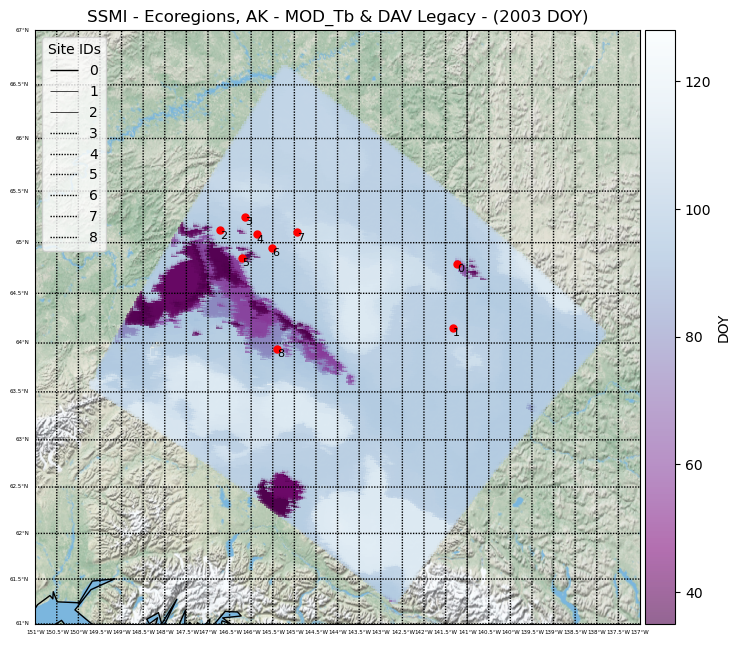

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read the CSV file and drop columns with all NaN values
df = pd.read_csv('/home/mabb21/Research/AKEcoregions/Filtered_Sites_with_SnowClasses.csv').dropna(axis=1, how='all')

# Assign unique IDs to each site
df['SiteID'] = df.index.astype(str)


# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type = 'year'
year = 2003
#plot_type = 'all'

# Data for plotting
if plot_type == 'all':
    array = MOD_DOY_df['Avg']
    label = 'AvgDOY' + str(subYears[0]) + '-' + str(subYears[-1])
    title = f"{sensor_SIR} - {areaname} - MOD_Tb & DAV Legacy - (Avg DOY {subYears[0]}-{subYears[-1]})"
elif plot_type == 'year':
    array = MOD_DOY_df[year]
    label = f"{year}DOY"
    title = f"{sensor_SIR} - {areaname} - MOD_Tb & DAV Legacy - ({year} DOY)"

# Set a few common things
graticule_fontsize = 4

# Create figure and axes instances
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Extend map boundaries by increasing lat/lon extents
extended_lat_offset = 2.0  # Increase latitudinal extent by 2 degrees
extended_lon_offset = 3.0  # Increase longitudinal extent by 2 degrees

# Create polar stereographic Basemap instance with extended boundaries
m = Basemap(projection='stere',
            lon_0=(lon_start + lon_end) / 2,
            lat_0=(lat_start + lat_end) / 2,
            lat_ts=90.,
            llcrnrlat=lat_start - extended_lat_offset,
            urcrnrlat=lat_end + extended_lat_offset,
            llcrnrlon=lon_start - extended_lon_offset,
            urcrnrlon=lon_end + extended_lon_offset,
            rsphere=6371200.,
            resolution='l',
            area_thresh=10000,
            epsg=3857)

m.drawcoastlines()
m.drawcountries()
m.drawstates()

parallels = np.arange(0., 90, 0.5)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=graticule_fontsize)

meridians = np.arange(0, 360., 0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=graticule_fontsize)

m.arcgisimage(service='World_Physical_Map', xpixels=1500, verbose=True)

# Debug: Check lengths
print(f"Length of pixel_lats: {len(pixel_lats)}")
print(f"Length of pixel_lons: {len(pixel_lons)}")
print(f"Length of array: {len(array)}")

# Ensure that the lengths match
if len(pixel_lats) != len(array) or len(pixel_lons) != len(array):
    print(f"Mismatch found! Length of pixel_lats: {len(pixel_lats)}, Length of pixel_lons: {len(pixel_lons)}, Length of array: {len(array)}")
    raise ValueError("Length of pixel_lats, pixel_lons, and array must be equal")

# Plot pixel data
x, y = m(pixel_lons, pixel_lats)
im = m.scatter(x, y, c=array, s=30, marker='s', lw=0, cmap='BuPu_r', alpha=.6)

# Plotting the sites from your DataFrame with coordinate labels
for index, row in df.iterrows():
    x, y = m(row['lon_start'], row['lat_start'])
    m.plot(x, y, 'ro', markersize=5)  # Plot each site as a red dot

    # Annotate the plot with the site name
    plt.text(x, y, f"{row['SiteID']}", fontsize=8, ha='left', va='top', color='black')

plt.title(title)

# Configure colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label='DOY')
#plt.clim(30, 145)  # Color bar limits

# Legend for site IDs
legend_entries = [f"{row['SiteID']}" for index, row in df.iterrows()]
ax.legend(legend_entries, loc='upper left', title="Site IDs")


# Save the figure
output_file_path = '/home/mabb21/Research/AKEcoregions/Plots/MeltmapLegacy.png'
plt.savefig(output_file_path, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

/home/mabb21/miniconda3/envs/cetb/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-17031882.091370855,8399737.889818357,-15250770.23867848,10446997.314774934&bboxSR=3857&imageSR=3857&size=1500,1724&dpi=96&format=png32&transparent=true&f=image


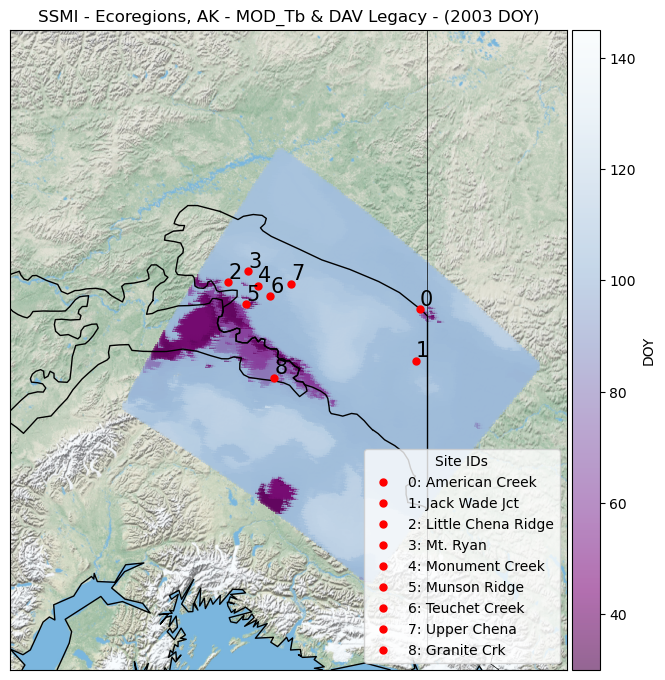

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read the CSV file and drop columns with all NaN values
df = pd.read_csv('/home/mabb21/Research/AKEcoregions/Filtered_Sites_with_SnowClasses.csv').dropna(axis=1, how='all')

# Assign unique IDs to each site
df['SiteID'] = df.index.astype(str)

# Read the shapefile
shp_file = '/home/mabb21/Research/Sites/Ecoregion/AKEcoregions105106.shp'
gdf = gpd.read_file(shp_file)


# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type = 'year'
year = 2003
#plot_type = 'all'

# Data for plotting
if plot_type == 'all':
    array = MOD_DOY_df['Avg']
    label = 'AvgDOY' + str(subYears[0]) + '-' + str(subYears[-1])
    title = f"{sensor_SIR} - {areaname} - MOD_Tb & DAV Legacy - (Avg DOY {subYears[0]}-{subYears[-1]})"
elif plot_type == 'year':
    array = MOD_DOY_df[year]
    label = f"{year}DOY"
    title = f"{sensor_SIR} - {areaname} - MOD_Tb & DAV Legacy - ({year} DOY)"

# Create figure and basemap instance
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='stere',
            lon_0=(lon_start + lon_end) / 2,
            lat_0=(lat_start + lat_end) / 2,
            lat_ts=90.,
            llcrnrlat=lat_start - 3.0,
            urcrnrlat=lat_end + 3.0,
            llcrnrlon=lon_start - 5.0,
            urcrnrlon=lon_end + 3.0,
            rsphere=6371200.,
            resolution='l',
            area_thresh=10000,
            epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.arcgisimage(service='World_Physical_Map', xpixels=1500, verbose=True)

# Plot pixel data
x, y = m(pixel_lons, pixel_lats)
im = m.scatter(x, y, c=array, s=30, marker='s', lw=0, cmap='BuPu_r', alpha=.6)

# Plot the shapefile
for geom in gdf.geometry:
    if geom.type == 'Polygon':
        xs, ys = geom.exterior.xy
        m.plot(xs, ys, 'k-', lw=1, latlon=True)  # Plotting as black lines
    elif geom.type == 'Point':
        x, y = geom.x, geom.y
        m.plot(x, y, 'ro', markersize=5, latlon=True)  # Plotting points


# Plotting the sites and preparing legend
handles = []  # Store handles for the legend
for index, row in df.iterrows():
    x, y = m(row['lon_start'], row['lat_start'])
    handle, = m.plot(x, y, 'ro', markersize=5)  # Plot each site as a red dot
    handles.append(handle)
    # Annotate each site with its name or ID
    plt.text(x, y, f"{row['SiteID']}", fontsize=15, ha='left', va='bottom')

# Legend for site IDs
legend_entries = [f"{row['SiteID']}: {row['Site']}" for index, row in df.iterrows()]
ax.legend(handles, legend_entries, loc='lower right', title="Site IDs")

plt.title(title)
plt.clim(30, 145)
# Configure colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label='DOY')

# Save the figure
output_file_path = '/home/mabb21/Research/AKEcoregions/Plots/MeltmapLegacy.png'
plt.savefig(output_file_path, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

/home/mabb21/miniconda3/envs/cetb/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-17031882.091370855,8399737.889818357,-15250770.23867848,10446997.314774934&bboxSR=3857&imageSR=3857&size=1500,1724&dpi=96&format=png32&transparent=true&f=image


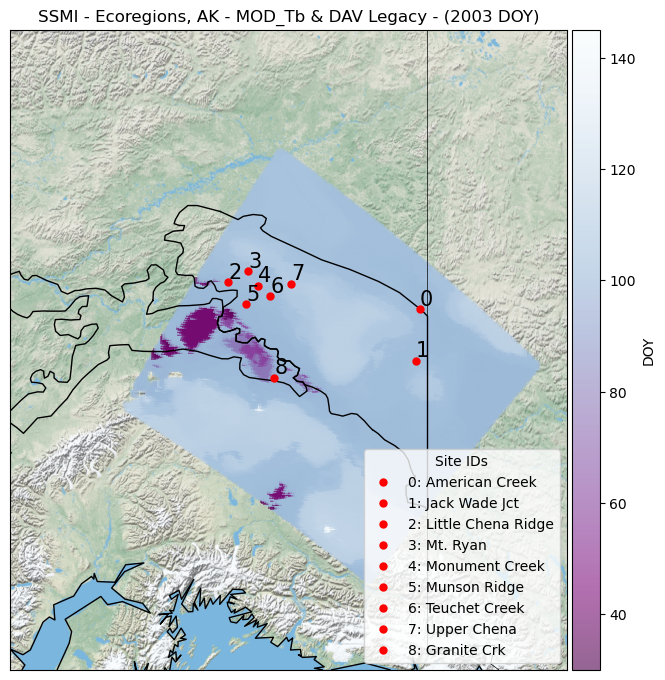

In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read the CSV file and drop columns with all NaN values
df = pd.read_csv('/home/mabb21/Research/AKEcoregions/Filtered_Sites_with_SnowClasses.csv').dropna(axis=1, how='all')

# Assign unique IDs to each site
df['SiteID'] = df.index.astype(str)

# Read the shapefile
shp_file = '/home/mabb21/Research/Sites/Ecoregion/AKEcoregions105106.shp'
gdf = gpd.read_file(shp_file)


# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type = 'year'
year = 2003
#plot_type = 'all'

# Data for plotting
if plot_type == 'all':
    array = MOD_DOY_df['Avg']
    label = 'AvgDOY' + str(subYears[0]) + '-' + str(subYears[-1])
    title = f"{sensor_SIR} - {areaname} - MOD_Tb & DAV Legacy - (Avg DOY {subYears[0]}-{subYears[-1]})"
elif plot_type == 'year':
    array2 = MOD_DOY_df[year]
    label = f"{year}DOY"
    title = f"{sensor_SIR} - {areaname} - MOD_Tb & DAV Legacy - ({year} DOY)"

# Create figure and basemap instance
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(projection='stere',
            lon_0=(lon_start + lon_end) / 2,
            lat_0=(lat_start + lat_end) / 2,
            lat_ts=90.,
            llcrnrlat=lat_start - 2.0,
            urcrnrlat=lat_end + 2.0,
            llcrnrlon=lon_start - 5.0,
            urcrnrlon=lon_end + 2.0,
            rsphere=6371200.,
            resolution='l',
            area_thresh=10000,
            epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.arcgisimage(service='World_Physical_Map', xpixels=1500, verbose=True)

# Plot pixel data
x, y = m(pixel_lons, pixel_lats)
im2 = m.scatter(x, y, c=array2, s=30, marker='s', lw=0, cmap='BuPu_r', alpha=.6)

# Plot the shapefile
for geom in gdf.geometry:
    if geom.type == 'Polygon':
        xs, ys = geom.exterior.xy
        m.plot(xs, ys, 'k-', lw=1, latlon=True)  # Plotting as black lines
    elif geom.type == 'Point':
        x, y = geom.x, geom.y
        m.plot(x, y, 'ro', markersize=5, latlon=True)  # Plotting points


# Plotting the sites and preparing legend
handles = []  # Store handles for the legend
for index, row in df.iterrows():
    x, y = m(row['lon_start'], row['lat_start'])
    handle, = m.plot(x, y, 'ro', markersize=5)  # Plot each site as a red dot
    handles.append(handle)
    # Annotate each site with its name or ID
    plt.text(x, y, f"{row['SiteID']}", fontsize=15, ha='left', va='bottom')

# Legend for site IDs
legend_entries = [f"{row['SiteID']}: {row['Site']}" for index, row in df.iterrows()]
ax.legend(handles, legend_entries, loc='lower right', title="Site IDs")

plt.title(title)
plt.clim(30, 145)
# Configure colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax, label='DOY')

# Save the figure
output_file_path = '/home/mabb21/Research/AKEcoregions/Plots/MeltmapLegacy2.png'
plt.savefig(output_file_path, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

/home/mabb21/miniconda3/envs/cetb/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-17031882.091370855,8399737.889818357,-15250770.23867848,10446997.314774934&bboxSR=3857&imageSR=3857&size=1500,1724&dpi=96&format=png32&transparent=true&f=image


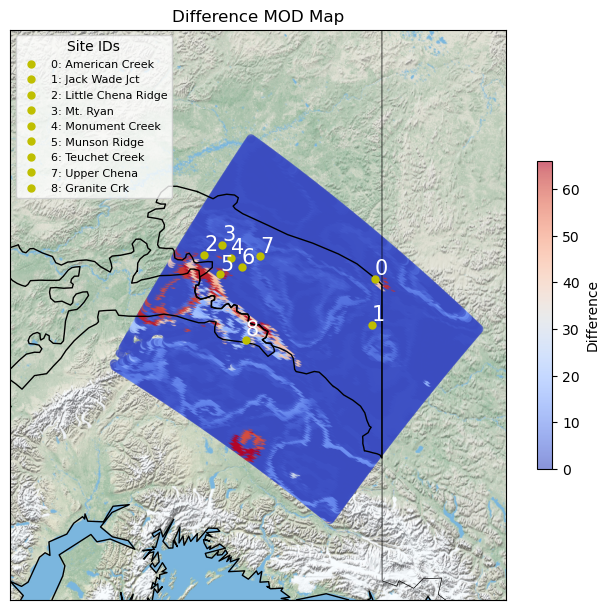

In [374]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize  # Import the Normalize class

# Read the CSV file and drop columns with all NaN values
df = pd.read_csv('/home/mabb21/Research/AKEcoregions/Filtered_Sites_with_SnowClasses.csv').dropna(axis=1, how='all')

# Assign unique IDs to each site
df['SiteID'] = df.index.astype(str)

# Read the shapefile
shp_file = '/home/mabb21/Research/Sites/Ecoregion/AKEcoregions105106.shp'
gdf = gpd.read_file(shp_file)

# Calculate the difference
difference = array2 - array

# Normalize the difference data for color mapping
norm = Normalize(vmin=np.min(difference), vmax=np.max(difference))

# Create the map and plot the difference
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='stere', lon_0=(lon_start + lon_end) / 2,
            lat_0=(lat_start + lat_end) / 2, lat_ts=90.,
            llcrnrlat=lat_start - 3.0, urcrnrlat=lat_end + 3.0,
            llcrnrlon=lon_start - 5.0, urcrnrlon=lon_end + 3.0,
            rsphere=6371200., resolution='l', area_thresh=10000, epsg=3857)
m.arcgisimage(service='World_Physical_Map', xpixels=1500, verbose=True)
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert geographic to map coordinates
x, y = m(pixel_lons, pixel_lats)

# Scatter plot for the difference, using the normalized values
im_diff = m.scatter(x, y, c=difference, cmap='coolwarm', norm=norm, s=30, alpha=0.6)

# Plot the shapefile
for geom in gdf.geometry:
    if geom.type == 'Polygon':
        xs, ys = geom.exterior.xy
        m.plot(xs, ys, 'k-', lw=1, latlon=True)  # Plotting as black lines
    elif geom.type == 'Point':
        x, y = geom.x, geom.y
        m.plot(x, y, 'ro', markersize=5, latlon=True)  # Plotting points


# Plotting the sites and preparing legend
handles = []  # Store handles for the legend
for index, row in df.iterrows():
    x, y = m(row['lon_start'], row['lat_start'])
    handle, = m.plot(x, y, 'yo', markersize=5)  # Plot each site as a red dot
    handles.append(handle)
    # Annotate each site with its name or ID
    plt.text(x, y, f"{row['SiteID']}", fontsize=15, ha='left', va='bottom', color='white')

# Legend for site IDs
legend_entries = [f"{row['SiteID']}: {row['Site']}" for index, row in df.iterrows()]
plt.legend(handles, legend_entries, loc='upper left', title="Site IDs", fontsize=8)

#plt.clim(30, 145)
# Add a colorbar
plt.colorbar(im_diff, label='Difference', orientation='vertical', shrink=0.5, pad=0.05)

plt.title('Difference MOD Map')

# Save the figure
output_file_path = '/home/mabb21/Research/AKEcoregions/Plots/MeltmapDifference.png'
plt.savefig(output_file_path, bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

# Load your data
df = pd.read_csv('/home/mabb21/Research/AKEcoregions/Filtered_Sites_with_SnowClasses.csv')
gdf = gpd.read_file('/home/mabb21/Research/Sites/Ecoregion/AKEcoregions105106.shp')

# Assuming pixel_lons and pixel_lats are available
pixel_lons = np.array([...])  # example data
pixel_lats = np.array([...])

# Example parameter data
parameter1 = np.random.rand(len(pixel_lons))  # random data for demonstration
parameter2 = np.random.rand(len(pixel_lons))

# Function to plot a parameter
def plot_parameter(data_array, title, cmap):
    fig, ax = plt.subplots(figsize=(8, 8))
    m = Basemap(projection='stere', lon_0=(lon_start + lon_end) / 2,
                lat_0=(lat_start + lat_end) / 2, lat_ts=90.,
                llcrnrlat=lat_start - 2.0, urcrnrlat=lat_end + 2.0,
                llcrnrlon=lon_start - 5.0, urcrnrlon=lon_end + 2.0,
                rsphere=6371200., resolution='l', area_thresh=10000, epsg=3857)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.arcgisimage(service='World_Physical_Map', xpixels=1500, verbose=True)
    
    x, y = m(pixel_lons, pixel_lats)
    sc = m.scatter(x, y, c=data_array, s=30, marker='s', lw=0, cmap=cmap, alpha=.6)
    plt.colorbar(sc, label='DOY', orientation='vertical')
    plt.title(title)
    plt.savefig(f'/home/mabb21/Research/AKEcoregions/Plots/{title}.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot the parameters
plot_parameter(parameter1, 'Parameter 1', 'viridis')
plot_parameter(parameter2, 'Parameter 2', 'plasma')

# Calculate the difference
difference = parameter1 - parameter2

# Plot the difference map
plot_parameter(difference, 'Difference Map', 'coolwarm')

In [ ]:
#color bars here https://matplotlib.org/stable/tutorials/colors/colormaps.html
#documentation on basemap https://matplotlib.org/basemap/users/laea.html

In [ ]:
# Trial-and-error decide on size for GRD vs. SIR scatter markers
#np.sqrt((1200)/8)^2
sGRD=700
sSIR=12

/home/mabb21/miniconda3/envs/cetb/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-16508680.484642472,9027065.293732036,-15996610.826993411,9741323.354045222&bboxSR=3857&imageSR=3857&size=1500,2092&dpi=96&format=png32&transparent=true&f=image


/home/mabb21/miniconda3/envs/cetb/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-16508680.484642472,9027065.293732036,-15996610.826993411,9741323.354045222&bboxSR=3857&imageSR=3857&size=1500,2092&dpi=96&format=png32&transparent=true&f=image


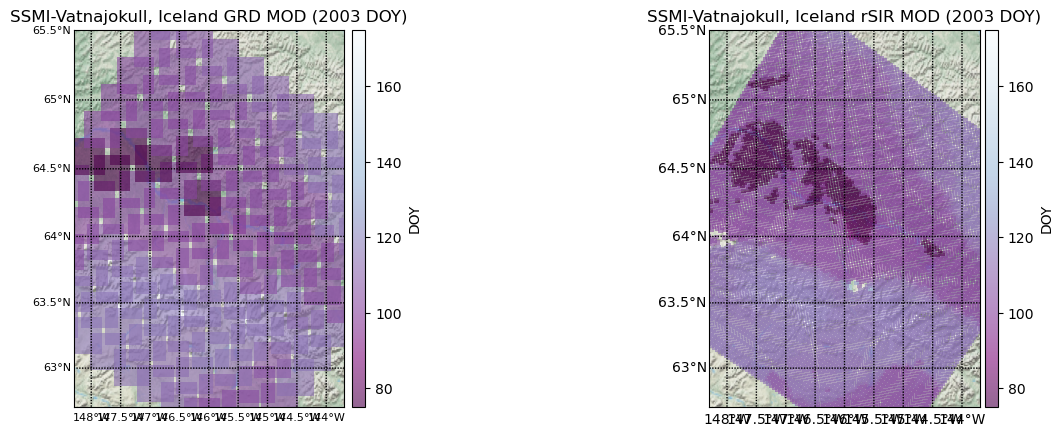

In [25]:
# 2plots left (GRD) and right (SIR)
#redo basemap to be in easegrid projection EASE2.0

# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type='year'  
year=2003
#plot_type='all'


if plot_type == 'all':
    sir_array = MOD_DOY_df['Avg']
    sir_title = sensor_SIR + '-' + Site + ' rSIR MOD (Avg DOY '+str(subYears[0])+'-'+str(subYears[-1])+')'
    grd_array = MOD_DOY_GRD_df['Avg']
    grd_title = sensor_GRD + '-' + Site + ' GRD MOD (Avg DOY '+str(subYears[0])+'-'+str(subYears[-1])+')'
elif plot_type == 'year':
    sir_array = MOD_DOY_df[year]
    sir_title = sensor_SIR + '-' + Site + ' rSIR MOD (' + str(year) + ' DOY)'
    grd_array = MOD_DOY_GRD_df[year]
    grd_title = sensor_GRD + '-' + Site + ' GRD MOD (' + str(year) + ' DOY)'

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Set a few common things
graticule_fontsize = 8

#min day of year to plot
minday=75
#max day of year to plot
maxday=175

# create polar stereographic Basemap instance.
axes[0].set_title(grd_title)
m = Basemap(ax=axes[0],projection='stere',
            lon_0=(lon_start+lon_end)/2,
            lat_0=(lat_start+lat_end)/2,lat_ts=90.,
            llcrnrlat=(lat_start-.3),
            urcrnrlat=(lat_end+.5),
            llcrnrlon=(lon_start-.3),
            urcrnrlon=(lon_end+.3),
            rsphere=6371200.,
            resolution='l',
            area_thresh=10000, 
            epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=graticule_fontsize)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=graticule_fontsize)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
#m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

x,y = m(pixel_lons_GRD, pixel_lats_GRD)
im0 = m.scatter(x, y, c=grd_array, 
                s=sGRD, marker='s',lw=0,cmap='BuPu_r', alpha=.6, vmin=minday, vmax=maxday) #RdBu, 

# Get the current axes and configure placement so colorbar will
# be 5% of ax width and the padding will be 0.08 in.
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.08)
cbar = plt.colorbar(im0, cax=cax, label='DOY')
#cbar.set_clim(minday, maxday)  #color bar limits

axes[1].set_title(sir_title)
m = Basemap(ax=axes[1],projection='stere',
            lon_0=(lon_start+lon_end)/2,
            lat_0=(lat_start+lat_end)/2,lat_ts=90.,
            llcrnrlat=(lat_start-.3),
            urcrnrlat=(lat_end+.5),
            llcrnrlon=(lon_start-.3),
            urcrnrlon=(lon_end+.3),
            rsphere=6371200.,
            resolution='l',
            area_thresh=10000, 
            epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
#m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

x,y = m(pixel_lons, pixel_lats)
im1 = m.scatter(x, y, c=sir_array, 
                s=sSIR, marker='s', lw=0,cmap='BuPu_r', alpha=.6,vmin=minday,vmax=maxday) #RdBu, 
#fig.colorbar(im1, ax=axes[1],label='DOY')
#plt.clim(75,175)  #color bar limits

# Get the current axes and configure placement so colorbar will
# be 5% of ax width and the padding will be 0.05 in.
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, label='DOY')
#cbar.set_clim(minday, maxday)  #color bar limits

plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# PLOT the MOD MAP - avg of all years or one year of interest - GRD
# Choose plot type - 'year' for one year of interest, 'all' for average of all years
plot_type='year'  
#plot_type='all'
year=2003

if plot_type=='all':
    array=MOD_DOY_array_GRD
    title=sensor_SIR+'-'++' - MOD - (Avg DOY '+str(Years[0])+'-'+str(Years[-1])+')'
elif plot_type=='year':
    array=MOD_DOY_array_GRD_year
    title=sensor_SIR+'-'+Site+' - MOD - ('+str(year)+' DOY)'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

x,y=m(pixel_lons_GRD, pixel_lats_GRD)
m.scatter(x,y,c=array, s=1200, marker='s',lw=0,cmap='BuPu_r', alpha=.6) #RdBu, 

plt.title(title)

plt.colorbar(label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()


# plot another blank map with no pixel overlay
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)
#m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)
m.readshapefile('/mnt/data3/rgi6.0/06_rgi60_Iceland', 'Vatnajokull', color='red', linewidth=1)

plt.title(title)
plt.show()

In [ ]:
#setup a dataframe so that all the data from ssmi and ssmis are read into one array for long term average
#need to decide which sensor has priority when there is overlap
#can create a reader that loops through enough sensors to get a full time series 
#(skip F10- orbit very elliptical and F19 - short)
#create that time series for the analysis, save for analysis
#
#save dataframes with MOD so that we can do other analysys
#pickle the data frame that is inside the MOD_array_DOY function 
#
#check in CETB_analysis.py that when it does the count/window it is in fact 
#saving the first occurrence of the count, even though it doesn't know until it gets to 3x

In [ ]:
#Add to this
#Plot of which pixels have melted as of a specific day

In [ ]:
#figure out refreeze? then from MOD to Freeze, count # of dates with Tb>=threshold (with or without DAV? might depend on site)

In [ ]:
#Add to this
#Plot of how many days (or occurrences) experienced melt 


In [ ]:
#Add to this
#Plot of how many short (1-2 occurrences) melt days EMEs prior to the first MOD
#From Jan 1 - MOD, Number of days with Tb>= threshold and DAV>= threshold (same thresholds)